# Gift Recommender Engine: Real Twitter User Evaluation

## Import Libraries and Scrape User Twitter

In [486]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

In [9]:
import tweepy
import pickle
from scripts.keys import *

def get_user_tweets(user_id, consumer_key, consumer_secret, access_token, access_token_secret):
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth)

    tweets = api.user_timeline(screen_name=user_id, count=200, include_rts=True, tweet_mode='extended')

    return tweets

In [10]:
twitter = TwitterKeys()
consumer_key = twitter.consumer_key
consumer_secret = twitter.consumer_secret
access_token = twitter.access_token
access_secret = twitter.access_secret

In [26]:
import json
user_id = ''

#tweets = get_user_tweets(user_id, consumer_key, consumer_secret, access_token, access_secret)

In [332]:
user_id = ''

tweets = get_user_tweets(user_id, consumer_key, consumer_secret, access_token, access_secret)

filename = open('cpintoval.sav', 'wb')
pickle.dump(tweets, filename)

## Data Compilation

In [98]:
import pandas as pd

def user_tweet_df(filename):
    
    tweets = pickle.load(open(filename, 'rb'))
    
    all_tweets = []
    username = tweets[0]._json['user']['screen_name']
    for tweet in tweets:
        all_tweets.append(tweet._json['full_text'])
        
    df = pd.DataFrame({'user': username, 'Tweet Content': all_tweets})
    return df

In [63]:
sohaib_df = user_tweet_df('tweets/sohaib.sav', 'rb')
sohaib_df.rename(columns={'tweets': 'Tweet Content'}, inplace=True)

In [99]:
carr1eg_df = user_tweet_df('tweets/carr.sav', 'rb')

In [113]:
user3_df = user_tweet_df('tweets/bintur.sav', 'rb')

In [142]:
sarah_df = user_tweet_df('tweets/sarah.sav', 'rb')

In [153]:
kyle_df = user_tweet_df('tweets/kyle.sav', 'rb')

In [368]:
may_df = user_tweet_df('tweets/may_ng.sav', 'rb')

In [168]:
marie_df = user_tweet_df('tweets/marie.sav', 'rb')

In [189]:
nisha_df = user_tweet_df('tweets/nisha.sav', 'rb')

In [210]:
dev_df = user_tweet_df('tweets/devina.sav', 'rb')

In [333]:
cpinto_df = user_tweet_df('tweets/cpintoval.sav', 'rb')

## Data Cleaning

In [314]:
import numpy as np
import re
import string
import nltk
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['im', "oh", "i'm", "lol", "gonna", 'ill'])
nlp = spacy.load('en_core_web_sm')

def spacy_lemmatize(text):
    if type(text) == list:
        doc = nlp(u"{}".format(' '.join(text)))
    else:
        doc = nlp(u"{}".format(text))
    lemmatized = list()
    for token in doc:
        lemmatized.append(token.lemma_)
    
    return lemmatized

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)


def tweet_preprocess(text):
    text=re.sub(r'http\S+', '',text)
    text = re.sub('@[^\s]+','',text)
    text = re.sub('&lt;/?[a-z]+&gt;', '', text)
    text = text.replace('&amp', '&')
    text = re.sub(r"[^\w\s]", "", text)
    text = deEmojify(text)
    text = text.split() #split into list
    #text = [re.sub(r'^https?:\/\/.*[\r\n]*', '', s, flags=re.MULTILINE) for s in text] #remove any links
    #text = [re.sub('@[^\s]+','', s) for s in text] #remove @
    text = [s.lower() for s in text] #convert every character into lowercase
    #text = [re.sub(rf"[{string.punctuation}]", " ", s) for s in text] #remove punctuations
    text = [re.sub(r'[0-9]', ' ', s) for s in text] #remove all digits
    text = ' '.join(text)  #resplits
    text = [s for s in text.split() if len(s) >= 2] #removes words with one word length
    text = [s for s in text if s not in stopwords] #remove all stopwords
    text = ' '.join(spacy_lemmatize(text)) #lemmatize text using spacy and join into a string
    text = ' '.join([s for s in text.split() if len(s) > 2])
    return text


class TweetCategory:

    def __init__(self, model, vectorizer, tweet_data, reference):
        self.data = tweet_data
        self.model = model
        self.vectorizer = vectorizer
        self.ref = reference
        self.analyzer = SentimentIntensityAnalyzer()

    def process_user_tweets(self):
        self.data['clean-tweet'] = self.data['Tweet Content'].map(tweet_preprocess)
        self.data = self.data[['Tweet Content', 'clean-tweet']].rename(columns={'Tweet Content': 'tweet'})

        self.data['vader-sentiment'] = self.data['tweet'].apply(lambda x: self.analyzer.polarity_scores(x))
        self.data['vader-pos'] = self.data['vader-sentiment'].apply(lambda x: x['pos'])
        self.data['vader-neu'] = self.data['vader-sentiment'].apply(lambda x: x['neu'])
        self.data['vader-neg'] = self.data['vader-sentiment'].apply(lambda x: x['neg'])
        self.data['vader-compound'] = self.data['vader-sentiment'].apply(lambda x: x['compound'])


    def predict_topics(self, sentiment_thresh, confidence_thresh):
        self.predict_df = self.data[(self.data['vader-compound'] >= sentiment_thresh) & (self.data['clean-tweet'] != '')]
        
        tweets_transformed = self.vectorizer.transform(self.predict_df['clean-tweet'])
        predicted_category = self.model.predict(tweets_transformed)

        p = np.array(self.model.decision_function(tweets_transformed))
        probability = np.exp(p)/np.sum(np.exp(p), axis=1, keepdims=True)
        probability_list = [max(prob) for prob in probability]

        self.predict_df['predicted_label'] = predicted_category
        self.predict_df['probability'] = probability_list
        self.predict_df['predicted'] = self.predict_df['predicted_label'].apply(lambda x: self.ref[x])

        top_categories = self.predict_df[self.predict_df['probability'] >= confidence_thresh]['predicted'].value_counts()[:5]       

        return top_categories

In [66]:
import pickle

# Naive Bayes Model
filename = open('models/nb_baseline2.sav', 'rb')
nb = pickle.load(filename)

# Support Vector Classifier Model
filename = open('models/linear_svc_baseline2.sav', 'rb')
ovr_svc = pickle.load(filename)

# Import Vectorizer
filename = open('models/tfidf_vectorizer2.sav', 'rb')
tfidf_model = pickle.load(filename)

# Import Reference Dictionary
filename = open('models/reference-dict.pickle', 'rb')
ref = pickle.load(filename)

In [76]:
key = {v: k for k, v in ref.items()}

## User 1

In [453]:
user2_class = TweetCategory(ovr_svc, tfidf_model, sohaib_df, key)
user2_class.process_user_tweets()
user2_topics = user2_class.predict_topics(0, 0.2)

In [454]:
user2_list = list(user2_topics.index)

In [455]:
user2_true = ['Sports', 'Nature', 'Electronics/Gadgets', 'Travel', 'Food']

## User 2

Expected: Travel, Work, Self-care, Tech, Books

In [106]:
carr_class = TweetCategory(ovr_svc, tfidf_model, carr1eg_df, key)
carr_class.process_user_tweets()
top_topics = carr_class.predict_topics(0, 0.2)

In [107]:
top_topics

Electronics/Gadgets    1
Name: predicted, dtype: int64

## User 3

Expected: Food, Tech, Business, Household/Cooking, Self-Care

In [449]:
user3_class = TweetCategory(ovr_svc, tfidf_model, user3_df, key)
user3_class.process_user_tweets()
user3_topics = user3_class.predict_topics(0, 0.2)

In [450]:
user3_true = ['Food', 'Electronics/Gadgets', 'Self-care', 'Business', 'Household/Cooking']

In [451]:
user3_list = list(user3_topics.index)

## User 4

In [371]:
user4_class = TweetCategory(ovr_svc, tfidf_model, sarah_df, key)
user4_class.process_user_tweets()
user4_topics = user4_class.predict_topics(0, 0.2)

In [378]:
user4_list = list(user4_topics.index)

In [386]:
user4_true = ['Art', 'Music', 'Self-care', 'Business', 'Travel']

## User 5

In [379]:
user5_class = TweetCategory(ovr_svc, tfidf_model, kyle_df, key)
user5_class.process_user_tweets()
user5_topics = user5_class.predict_topics(0, 0.15)

In [476]:
user5_true = ['Coffee', 'Sports', 'Music', 'Gaming', 'Travel']

In [477]:
user5_list = list(user5_topics.index)

## User 6

Expected: Music (likes to sing), Self-care (always stressed), Work or Business (very work oriented), Art (likes to draw). Bad topics: books, sports, alcohol, coffee, household.

In [369]:
user6_class = TweetCategory(ovr_svc, tfidf_model, may_df, key)
user6_class.process_user_tweets()
user6_topics = user6_class.predict_topics(0, 0.2)

In [392]:
user6_true = ['Music', 'Self-care', 'Work', 'Business', 'Art']

In [391]:
user6_list = list(user6_topics.index)

## User 7

In [365]:
user7_class = TweetCategory(ovr_svc, tfidf_model, marie_df, key)
user7_class.process_user_tweets()
user7_topics = user7_class.predict_topics(0, 0.2)

In [396]:
user7_true = ['Electronics/Gadgets', 'Work', 'Nature', 'Books', 'Music']

In [394]:
user7_list = list(user7_topics.index)

## User 8

In [362]:
user8_class = TweetCategory(ovr_svc, tfidf_model, nisha_df, key)
user8_class.process_user_tweets()
user8_topics = user8_class.predict_topics(0, 0.2)

In [397]:
user8_list = list(user8_topics.index)

In [472]:
user8_true  = ['Books', 'Nature', 'Work', 'Self-care', 'Household']

## User 9

In [360]:
user9_class = TweetCategory(ovr_svc, tfidf_model, dev_df, key)
user9_class.process_user_tweets()
user9_topics = user9_class.predict_topics(0, 0.2)

In [405]:
user9_true = ['Music', 'Alcohol', 'Sports', 'Movies', 'Self-care']

In [403]:
user9_list = list(user9_topics.index)

## User 10

In [422]:
user10_true = ['Electronics/Gadgets', 'Gamers', 'Business', 'Music', 'Coffee']

In [357]:
user10_class = TweetCategory(ovr_svc, tfidf_model, cpinto_df, key)
user10_class.process_user_tweets()
user10_topics = user10_class.predict_topics(0, 0.2)

In [406]:
user10_list = list(user10_topics.index)

In [468]:
user10_list

['Electronics/Gadgets', 'Gamers', 'Business', 'Movies', 'Nature']

## Evaluation Metrics 

#### How does the prediction performance change when we increase the number of topics predicted?

In [414]:
def get_percent_correct(predicted_list, true_list, top_n):
    num_correct = 0
    for i in predicted_list[:top_n]:
        if i in true_list:
            num_correct += 1
    return num_correct/top_n * 100

In [495]:
def get_score(user_list, user_true):
    result = list()
    if len(user_list) == len(user_true):
        for i in range(len(user_list)):
            score = get_percent_correct(user_list, user_true, i+1)
            result.append(score)
    e
    return np.array(result)

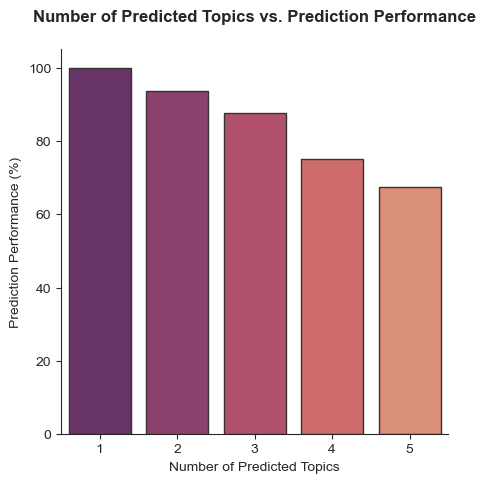

In [654]:
user2_scores = get_score(user2_list, user2_true)
user3_scores = get_score(user3_list, user3_true)
user4_scores = get_score(user4_list, user4_true)
user5_scores = get_score(user5_list, user5_true)
#user6_scores = get_score(user6_list, user6_true) #only predicted 3 categories
user7_scores = get_score(user7_list, user7_true)
user8_scores = get_score(user8_list, user8_true)
user9_scores = get_score(user9_list, user9_true)
user10_scores = get_score(user10_list, user10_true)

all_scores = np.array([user2_scores, user3_scores, user4_scores, 
                       user5_scores, user7_scores, 
                       user8_scores, user9_scores, user10_scores])

#results = pd.DataFrame(all_scores, columns=[i for i in range(1,6)])
#results = results[1].append([results[2], results[3], results[4], results[5]]).reset_index(drop=True).reset_index()
#labels = np.array([[i] * 8 for i in range(1, 6)]).reshape(-1, 1)
#results['labels'] = labels

average_scores = all_scores.sum(axis=0)/8
labels = [i for i in range(1,6)]
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(x=labels, y=average_scores, palette='flare_r', edgecolor='.2')
ax.set_ylim([0, 105])
ax.set(xlabel='Number of Predicted Topics', ylabel='Prediction Performance (%)')
ax.set_title('Number of Predicted Topics vs. Prediction Performance', fontsize=12,fontweight='bold', y=1.05)
sns.despine()

#### Check topic similarity using Glove Model

In [667]:
import gensim.downloader as api

model_glove_twitter = api.load("glove-twitter-25")

[==================================================] 100.0% 104.8/104.8MB downloaded


In [783]:
def get_similarity_score(row):
    doc = nlp(row['clean-tweet'])
    sim_score = list()
    
    for token in doc:
        if token.pos_ == 'NOUN':
            try:
                sim_score.append(model_glove_twitter.similarity(token.text, row['predicted'].lower()))
            except:
                sim_score.append(0)
    try:
        average = sum(sim_score)/len(sim_score)
    except:
        average = 0
    
    return average

In [961]:
def get_average_scores(df, conf_threshold):
    over_list = df[df.probability >= conf_threshold]['score'].to_list()
    under_list = df[df.probability < conf_threshold]['score'].to_list()
    
    ave_over = sum(over_list)/len(over_list) 
    ave_under = sum(under_list)/len(under_list) 
    
    return [ave_over, ave_under]

In [962]:
all_df = [user2_class, user3_class, user4_class, user5_class, user7_class, user8_class, user9_class]

In [963]:
def get_results(all_df, conf_threshold):
    average_scores = list()
    for df in all_df:
        df.predict_df['score'] = df.predict_df.apply(get_similarity_score, axis=1)
        average_scores.append(get_average_scores(df.predict_df, conf_threshold))
    above = [i[0] for i in average_scores]
    below = [i[1] for i in average_scores]
    above_average = sum(above)/len(above)
    below_average = sum(below)/len(below)
    return [above_average, below_average]

In [964]:
average_01 = get_results(all_df, 0.1)
average_012 = get_results(all_df, 0.12)
average_014 = get_results(all_df, 0.14)
average_016 = get_results(all_df, 0.16)
average_018 = get_results(all_df, 0.18)
average_02 = get_results(all_df, 0.20)
average_022 = get_results(all_df, 0.22)
average_024 = get_results(all_df, 0.24)

In [965]:
all_averages = [average_01, average_012, average_014, average_016, average_018, average_02, average_022, average_024]
average_df = pd.DataFrame(columns=['above', 'below'])
for i in all_averages:
    average_df.loc[len(average_df)] = i

In [966]:
average_df['threshold'] = [0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24]

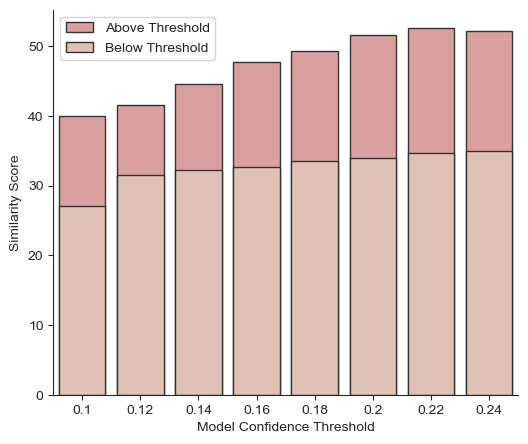

In [940]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.barplot(x="threshold", y="above", data=average_df,
            label="Above Threshold", color="#e39695", edgecolor='.2', ax=ax)
sns.barplot(x="threshold", y="below", data=average_df,
           label="Below Threshold", color="#e6beae", edgecolor='.2', ax=ax)
plt.xlabel('Model Confidence Threshold')
plt.ylabel('Similarity Score')
plt.legend()
sns.despine()

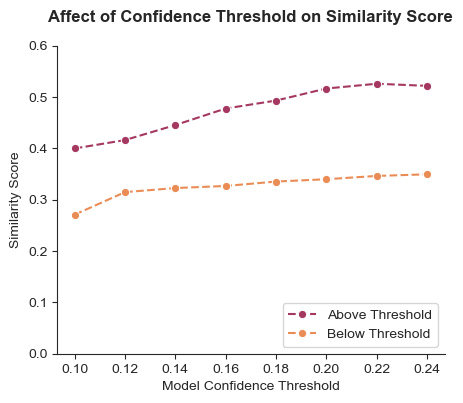

In [968]:
fig, ax = plt.subplots(figsize=(5, 4))
sns.lineplot(x="threshold", y="above", data=average_df,
            label="Above Threshold", linestyle='--', marker='o', color='#a53860', ax=ax)
sns.lineplot(x="threshold", y="below", data=average_df,
           label="Below Threshold", linestyle='--', marker='o', color='#ea8c55', ax=ax)
plt.xlabel('Model Confidence Threshold')
plt.ylabel('Similarity Score')
ax.set_ylim([0, 0.6])
ax.set_title('Affect of Confidence Threshold on Similarity Score', fontweight='bold', fontsize=12, y=1.05)
plt.legend(loc='lower right')
sns.despine()

In [854]:
user_similarity_scores = pd.DataFrame(average_scores).agg({0: 'mean', 1: 'mean'}).reset_index().rename(columns={'index':'label', 0:'score'})

In [855]:
user_similarity_scores['label'] = ['Greater than 0.2', 'Less than 0.2']

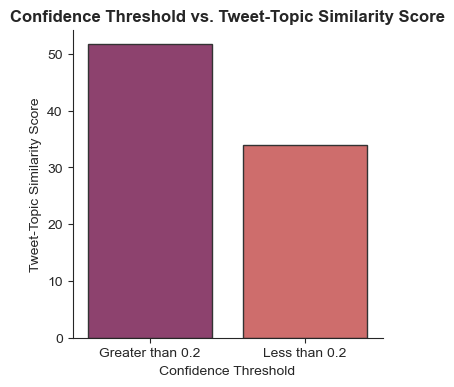

In [863]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.barplot(x='label', y='score', data=user_similarity_scores, palette='flare_r', edgecolor='.2')
plt.xlabel('Confidence Threshold')
plt.ylabel('Tweet-Topic Similarity Score')
plt.title('Confidence Threshold vs. Tweet-Topic Similarity Score', fontweight='bold', fontsize=12)
sns.despine()